In [6]:
%%capture
! pip install -r requirements.txt

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import shutil
import json

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = "cuda" if torch.cuda.is_available() else "cpu". # -- Use this line if have CUDA GPU
device

device(type='mps')

In [10]:
# -- Create the file structure
def make_file_structure():
    base_dir = "."
    dirs = ["images/train", "images/val", "labels/train", "labels/val"]

    for d in dirs:
        os.makedirs(os.path.join(base_dir, d), exist_ok=True)

# -- Add data to images folder
def add_images_to_file(src, dest, start=0, end=None, train=True):
    src_path = os.path.join(src, "data")

    if train:
        dest_path = os.path.join(dest, "train")
    else:
        dest_path = os.path.join(dest, "val")

    # -- Remove existing folder from previous run and make a new one
    if os.path.exists(dest_path):
        shutil.rmtree(dest_path)
    os.makedirs(dest_path, exist_ok=True)

    # Collecting all the image files
    files = [f for f in os.listdir(src_path) if f.endswith((".jpg", ".png"))]
    files = sorted(files)
    
    # If end is None, process all files
    if end is None:
        end = len(files)
    
    files = files[start:end]

    # -- Copying the selected files
    for file in files:
        shutil.copy(os.path.join(src_path, file), os.path.join(dest_path, file))
    
    print(f"Copied {len(files)} images to {dest_path}")
    return files 

# -- Adding labels to label folder
def add_labels_to_file(src, dest, image_files=None, train=True):
    json_file = os.path.join(src, "coco.json")

    with open(json_file, 'r') as f:
        data = json.load(f)
    
    annotations = data["annotations"]
    images = {img["id"]: img for img in data["images"]}

    # Create a mapping from category_id to index
    categories = {cat["id"]: idx for idx, cat in enumerate(data["categories"])}

    # Create destination directory if it doesn't exist
    label_dir = os.path.join(dest, "train" if train else "val")
    os.makedirs(label_dir, exist_ok=True)
    
    # If image_files is provided, filter to only those images
    if image_files is not None:
        image_filenames = set(image_files)
        # Filter images dict to only include the specified files
        images = {img_id: img_info for img_id, img_info in images.items() 
                  if os.path.basename(img_info["file_name"]) in image_filenames}
    
    # Group annotations by image_id (only for filtered images)
    img_anno = {}
    for anno in annotations:
        img_id = anno["image_id"]
        if img_id in images:
            if img_id not in img_anno:
                img_anno[img_id] = []
            img_anno[img_id].append(anno)
    
    # Process each image
    processed = 0
    for img_id, annos in img_anno.items():
        img_info = images[img_id]
        img_width = img_info["width"]
        img_height = img_info["height"]
        img_filename = img_info["file_name"]

        # Extract just the filename
        base_filename = os.path.basename(img_filename)
        
        # Create label files
        label_filename = os.path.splitext(base_filename)[0] + ".txt"
        label_path = os.path.join(dest, "train" if train else "val", label_filename)

        # Write in YOLO format
        with open(label_path, "w") as l:
            for anno in annos:
                category_id = anno["category_id"]
                
                if category_id not in categories:
                    print(f"Warning: Category {category_id} not found")
                    continue
                    
                class_idx = categories[category_id]

                bbox = anno["bbox"]

                x, y, w, h = bbox
                x_center = (x + w / 2) / img_width
                y_center = (y + h / 2) / img_height
                w_norm = w / img_width
                h_norm = h / img_height

                l.write(f"{class_idx} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")
        
        processed += 1
    
    print(f"Processed {processed} label files in {label_dir}")


make_file_structure()

# Try with the first 10 images for both train and val
# -- Mess around with end to change number of images processed
train_files = add_images_to_file("./images_thermal_train", "./images", start=0, end=10, train=True)
add_labels_to_file("./images_thermal_train", "./labels", image_files=train_files, train=True)

val_files = add_images_to_file("./images_thermal_val", "./images", start=0, end=10, train=False)
add_labels_to_file("./images_thermal_val", "./labels", image_files=val_files, train=False)

Copied 10 images to ./images/train
Processed 10 label files in ./labels/train
Copied 10 images to ./images/val
Processed 10 label files in ./labels/val


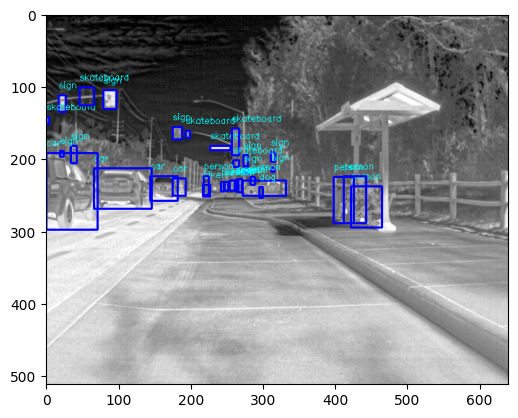

In [17]:
# Visualizing the first image and annotations

import cv2
import yaml

with open("config.yml", "r") as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml["names"]
# first_img = cv2.imread('./images/train/')
first_img_path = "./images/train/" + os.listdir("./images/train/")[0]
first_img = cv2.imread(first_img_path)

plt.imshow(cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB))

first_img_anot_path = "./labels/train/" + os.listdir("./labels/train/")[0]

with open(first_img_anot_path, 'r') as f:
    annot = f.readlines()
    for cls, xc, yx, w, h in [line.strip().split() for line in annot]:
        cv2.rectangle(first_img, 
                      (int((float(xc) - float(w)/2) * first_img.shape[1]), int((float(yx) - float(h)/2) * first_img.shape[0])),
                      (int((float(xc) + float(w)/2) * first_img.shape[1]), int((float(yx) + float(h)/2) * first_img.shape[0])),
                      (255, 0, 0), 2)
        label = class_names[int(cls)]
        cv2.putText(first_img, label,
                    (int((float(xc) - float(w)/2) * first_img.shape[1]), int((float(yx) - float(h)/2) * first_img.shape[0]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
        
plt.imshow(cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB))

# Model

In [12]:
# from ultralytics import YOLO

# model = YOLO("yolov8n.pt")

# ''' model.train(
#     data="thermal.yaml",
#     imgsz=640,
#     epochs=100,
#     batch=16,
#     device=device,   # pass it here instead of using .to()
#     hsv_h=0, hsv_s=0, hsv_v=0,  # no color augment for thermal
#     degrees=0, shear=0, perspective=0,
# ) '''

# model.train(data="config.yml", epochs=50, imgsz=640, batch=16, device=device)
